# Installing packages:

In [ ]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Graph data:

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
datasets = ["Cora", "CiteSeer", "PubMed"]

for dataset in datasets:
    datagraph = Planetoid(root = ".", name = dataset)
    data = datagraph[0]

    # print information about the dataset:
    print(f"\n We are using dataset: {datagraph}")
    print(f'Number of nodes: {data.x.shape[0]}')
    print(f'Dim of feature vector per node: {datagraph.num_features}') # dimension of feature vector per node
    print(f'Number of classes: {datagraph.num_classes}')
    print(f'Edges are directed: {data.is_directed()}')
    print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Graph has loops: {data.has_self_loops()}')
    print(f"Number of nodes used for train: {sum(data.train_mask)}")
    print(f"Number of nodes used for validation: {sum(data.val_mask)}")
    print(f"Number of nodes used for test: {sum(data.test_mask)}")

    # # visualization the graph:
    # G = to_networkx(data, to_undirected=True)
    # plt.figure(figsize=(12,12))
    # plt.axis('off')
    # nx.draw_networkx(G,
    #             pos=nx.spring_layout(G, seed=0),
    #             with_labels=True,
    #             node_size=100,
    #             node_color=data.y,
    #             cmap="hsv",
    #             vmin=-2,
    #             vmax=3,
    #             width=0.5,
    #             edge_color="grey",
    #             font_size=4
    #             )
    # plt.show()


 We are using dataset: Cora()
Number of nodes: 2708
Dim of feature vector per node: 1433
Number of classes: 7
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of nodes used for train: 140
Number of nodes used for validation: 500
Number of nodes used for test: 1000

 We are using dataset: CiteSeer()
Number of nodes: 3327
Dim of feature vector per node: 3703
Number of classes: 6
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False
Number of nodes used for train: 120
Number of nodes used for validation: 500
Number of nodes used for test: 1000

 We are using dataset: PubMed()
Number of nodes: 19717
Dim of feature vector per node: 500
Number of classes: 3
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of nodes used for train: 60
Number of nodes used for validation: 500
Number of nodes used for test: 1000


## Simple visualization for Cora dataset:


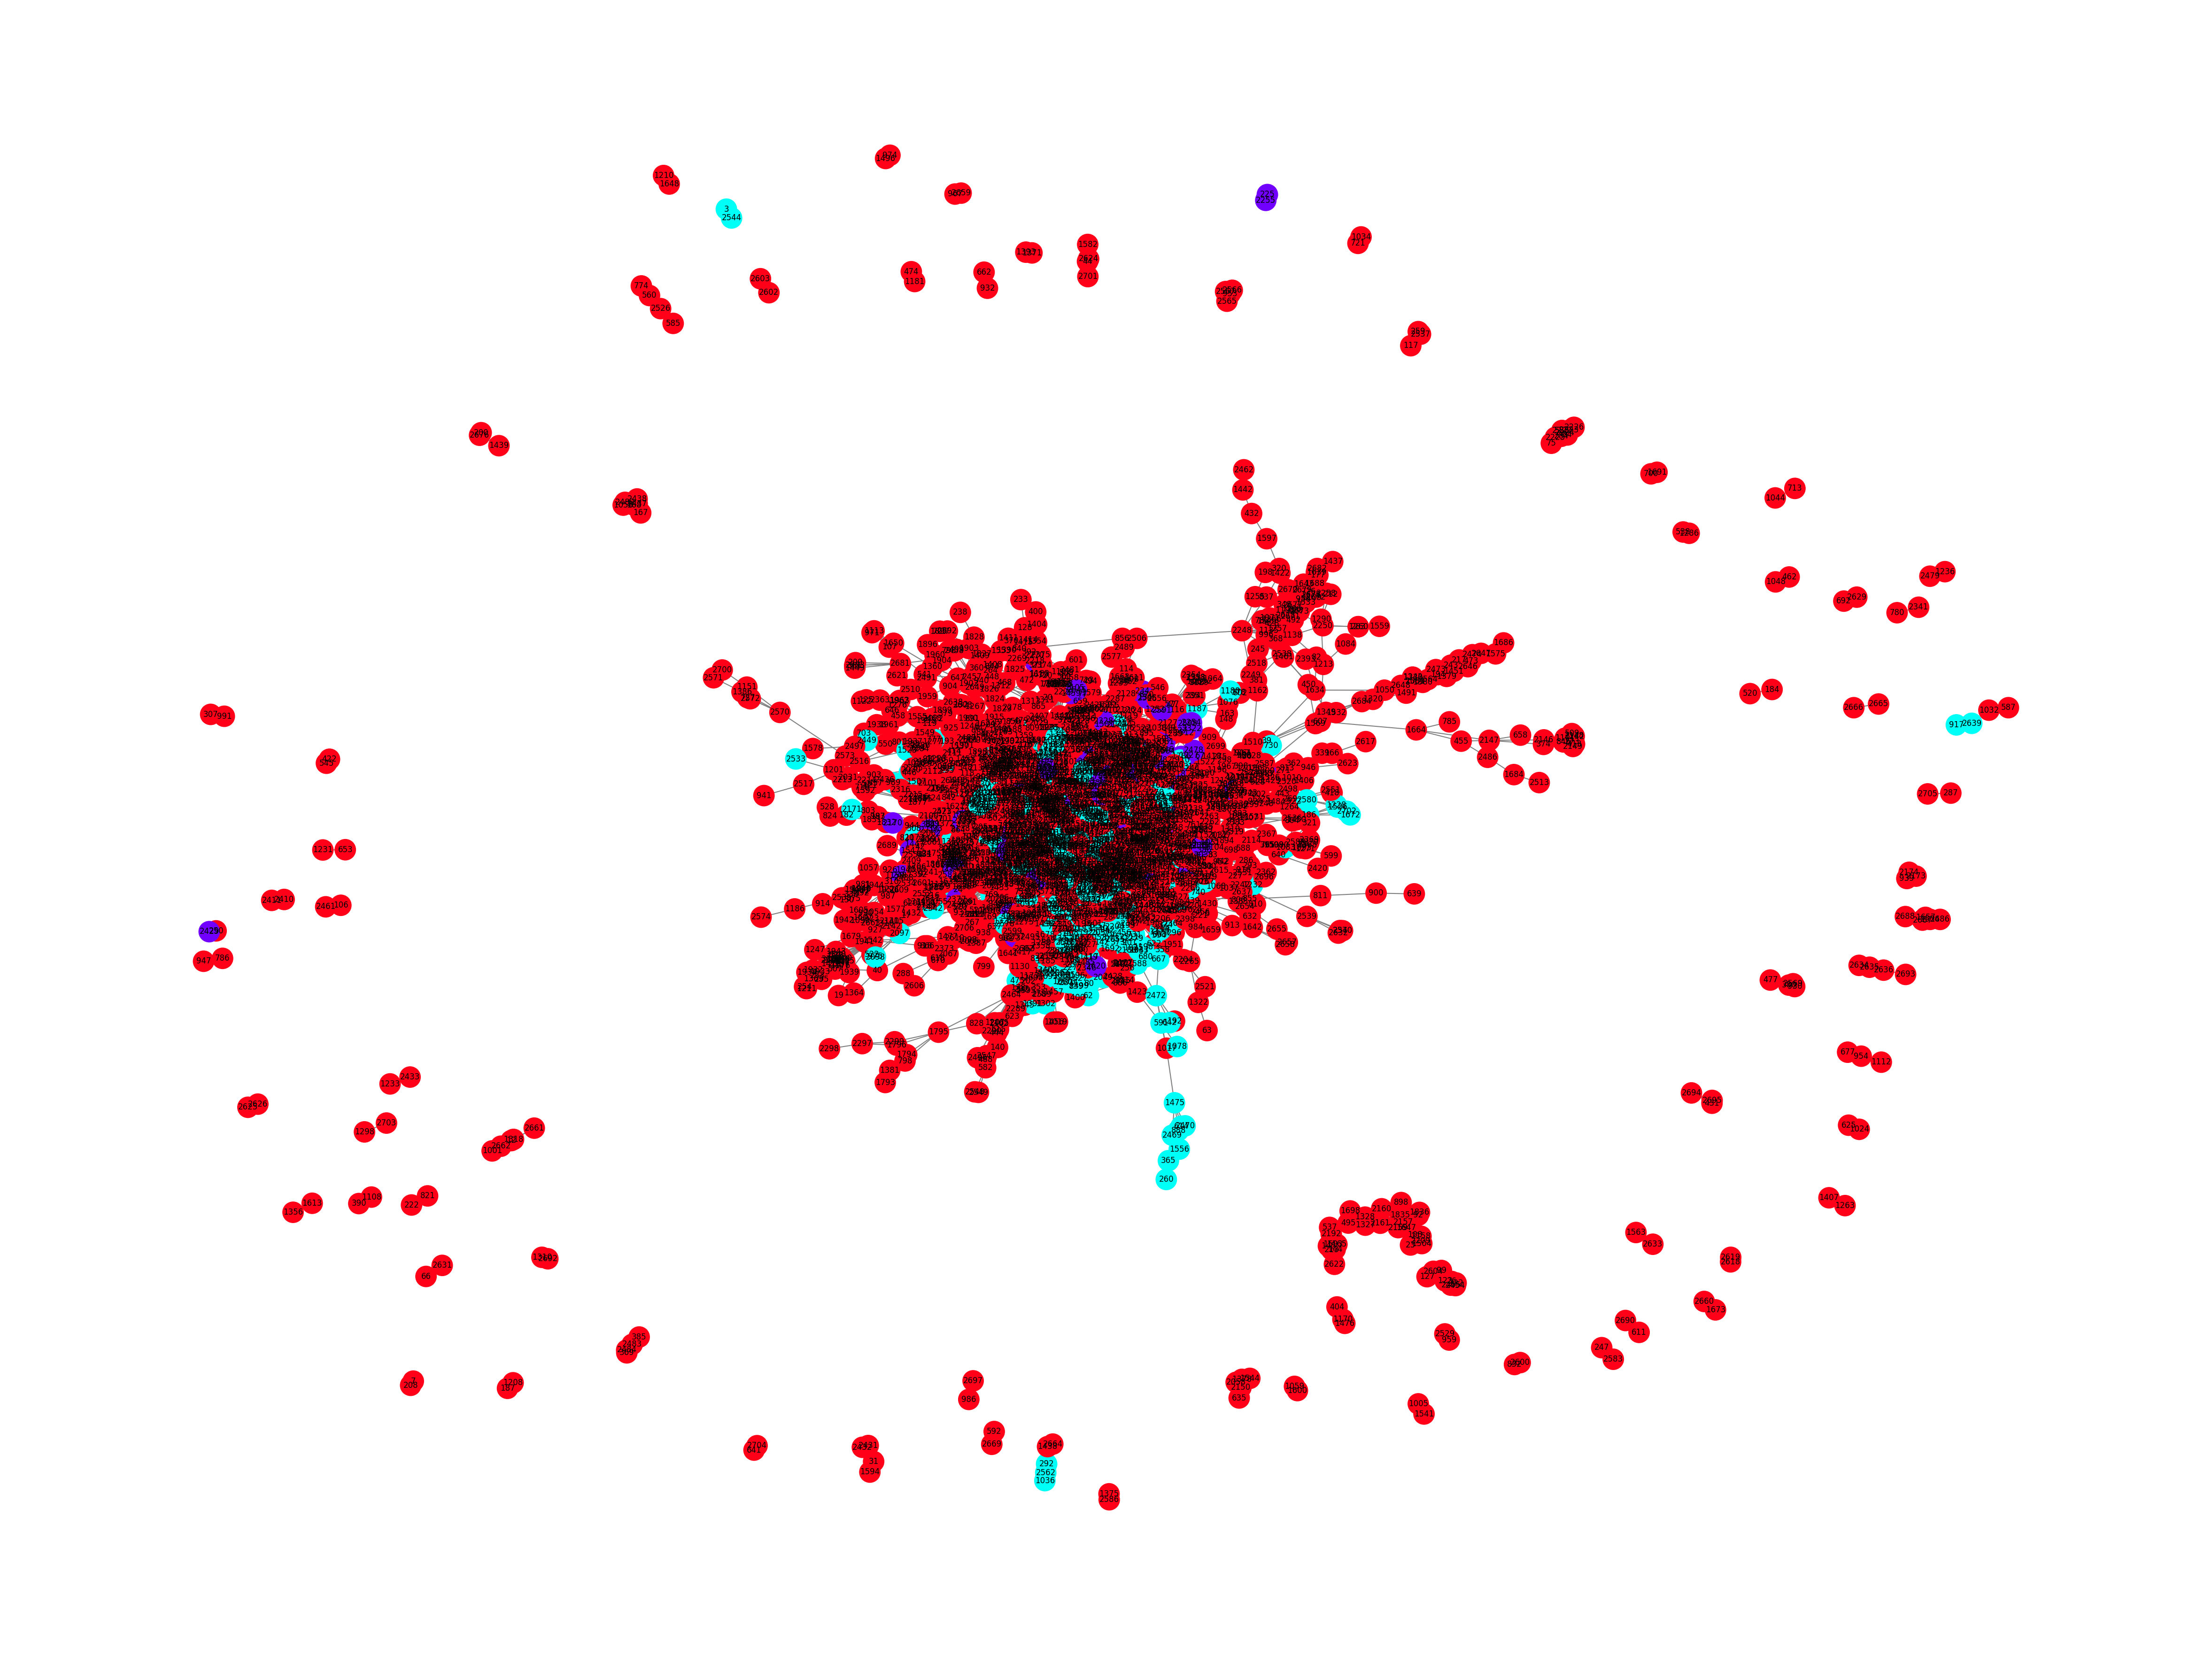

In [ ]:
Cora = Planetoid(root = ".", name = "Cora")[0]
G = to_networkx(Cora, to_undirected=True)
plt.figure(figsize=(20,15))
plt.axis('off')
nx.draw_networkx(G,
            pos=nx.spring_layout(G, seed=0),
            with_labels=True,
            node_size=100,
            node_color=Cora.y,
            cmap="hsv",
            vmin=-2,
            vmax=2,
            width=0.5,
            edge_color="grey",
            font_size=4
            )
plt.show()

## Plot data with node degrees:



 We are using dataset: Cora()

 We are using dataset: CiteSeer()

 We are using dataset: PubMed()


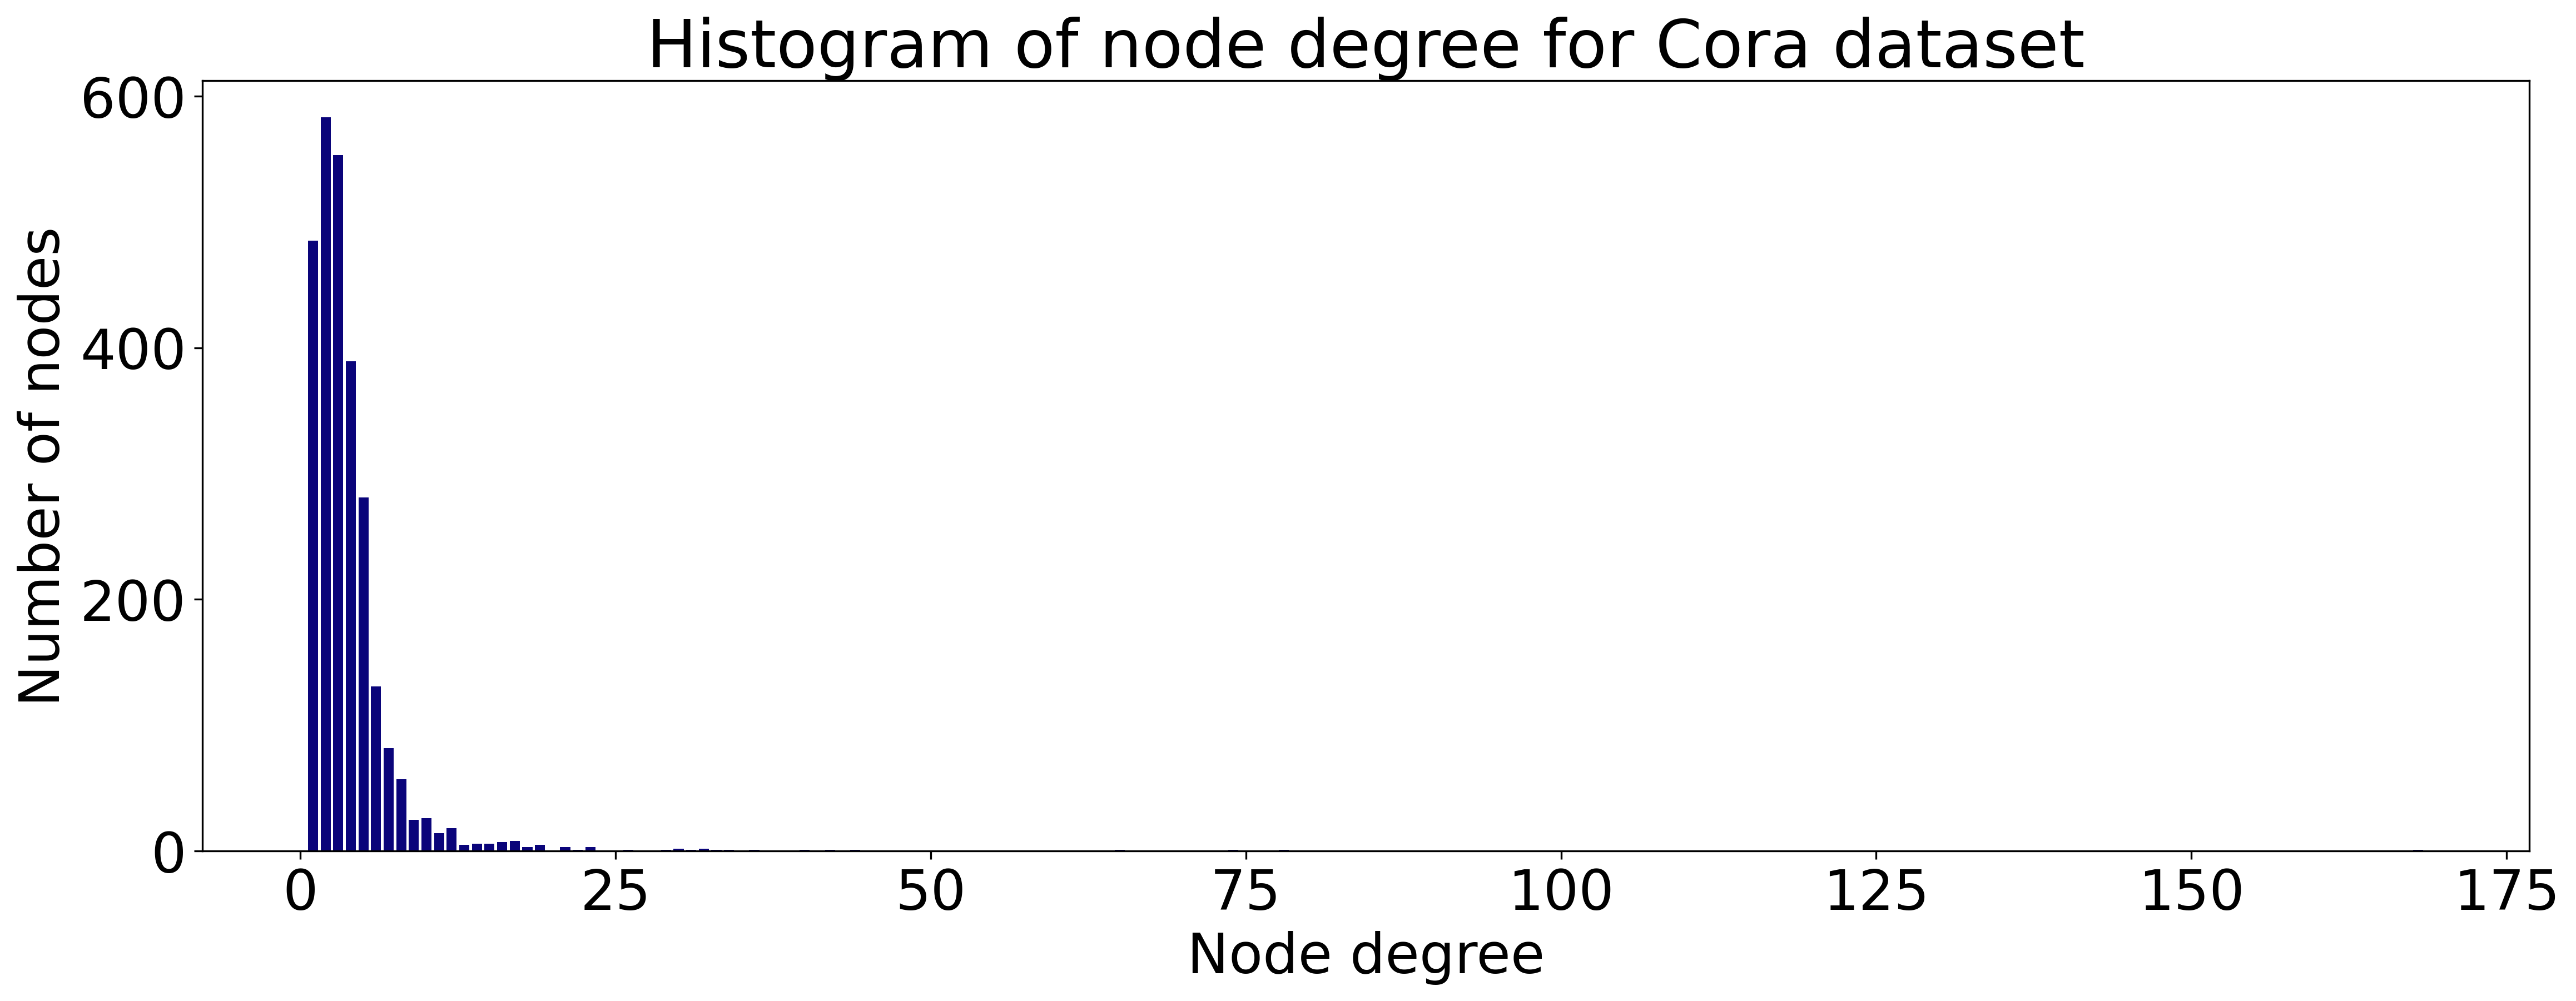

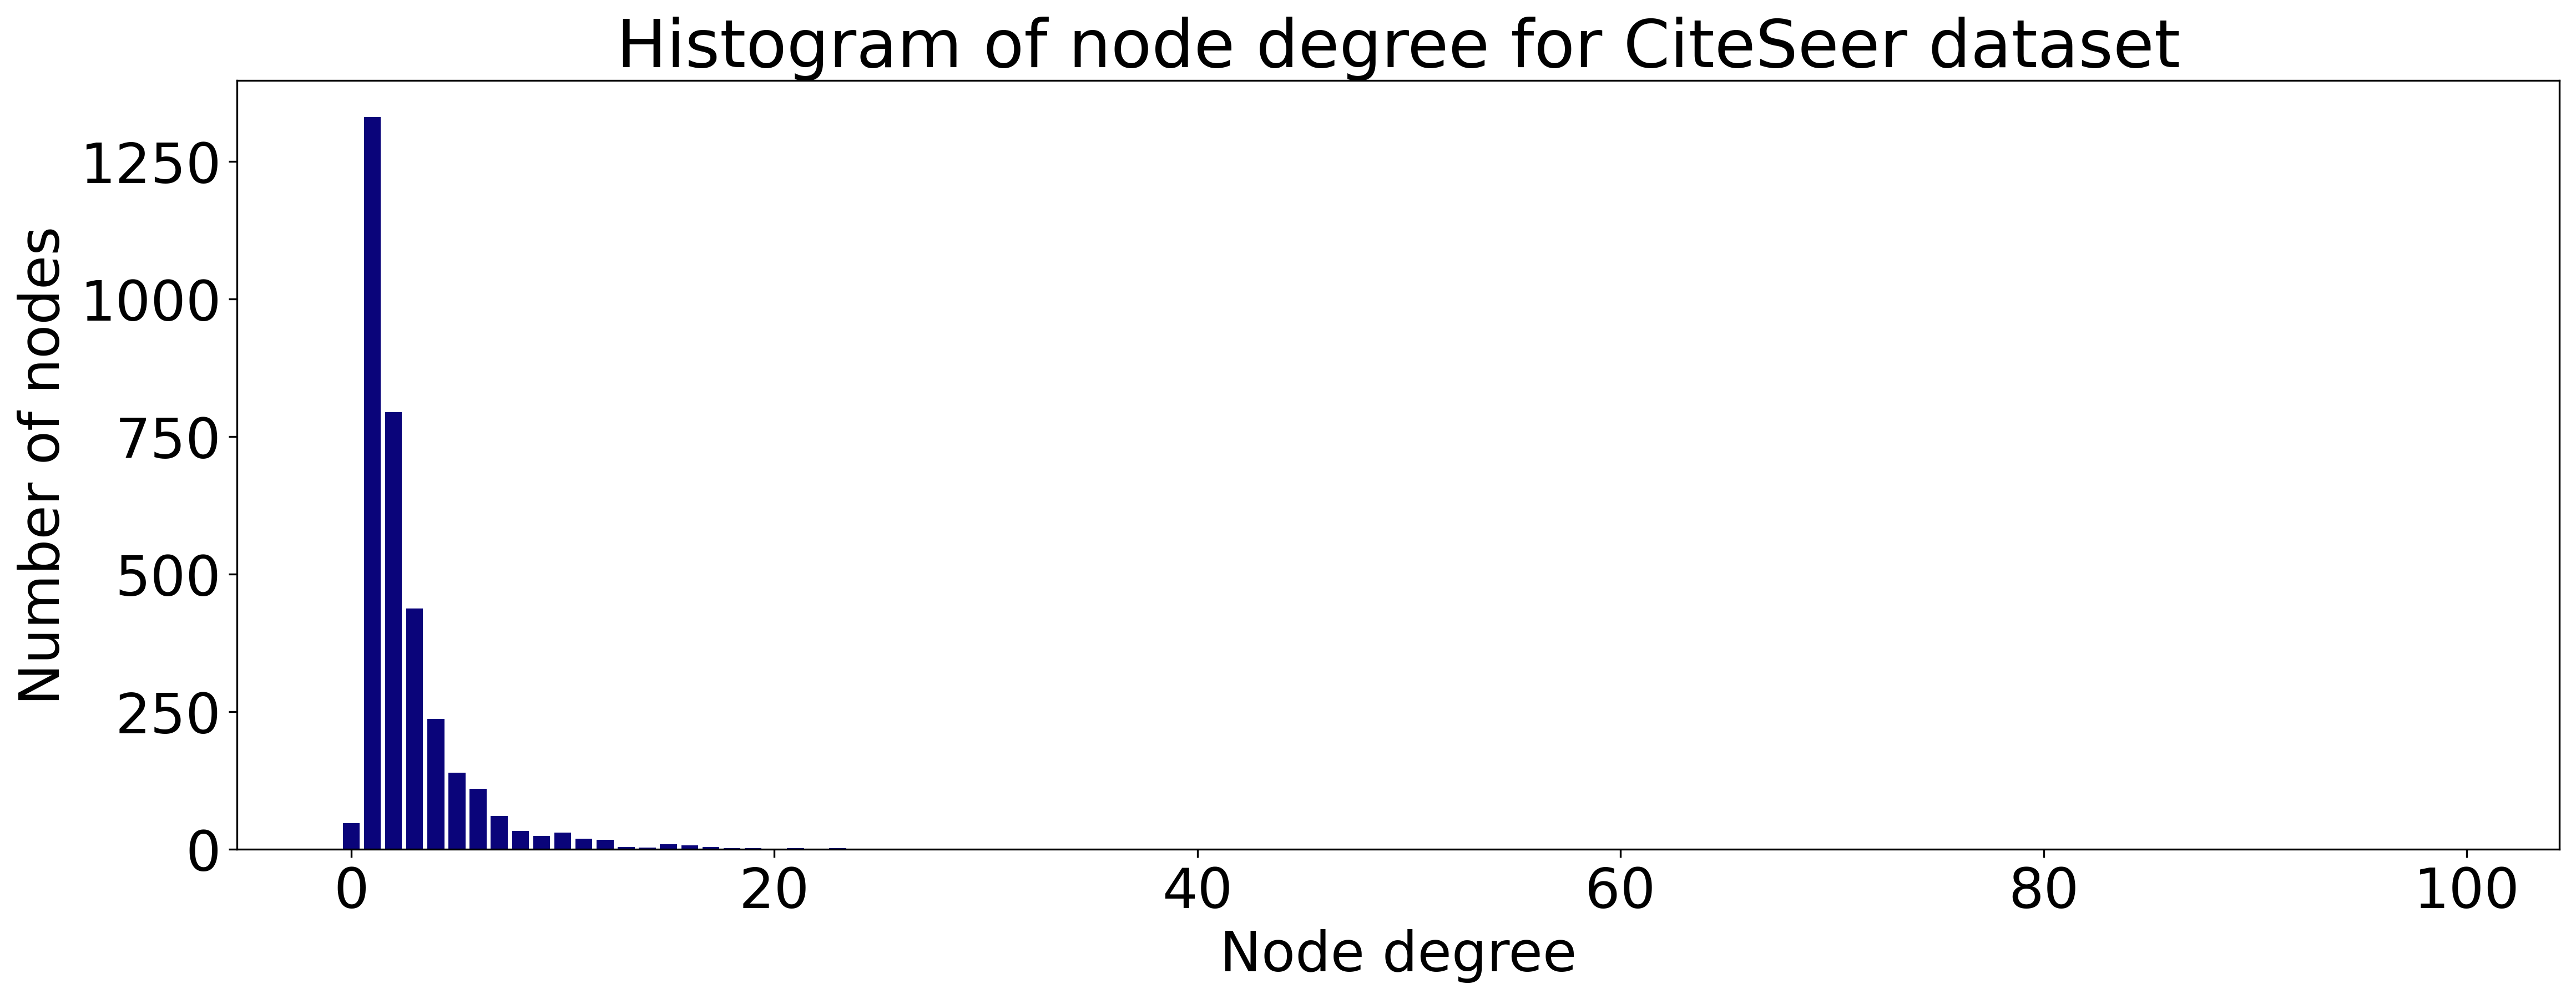

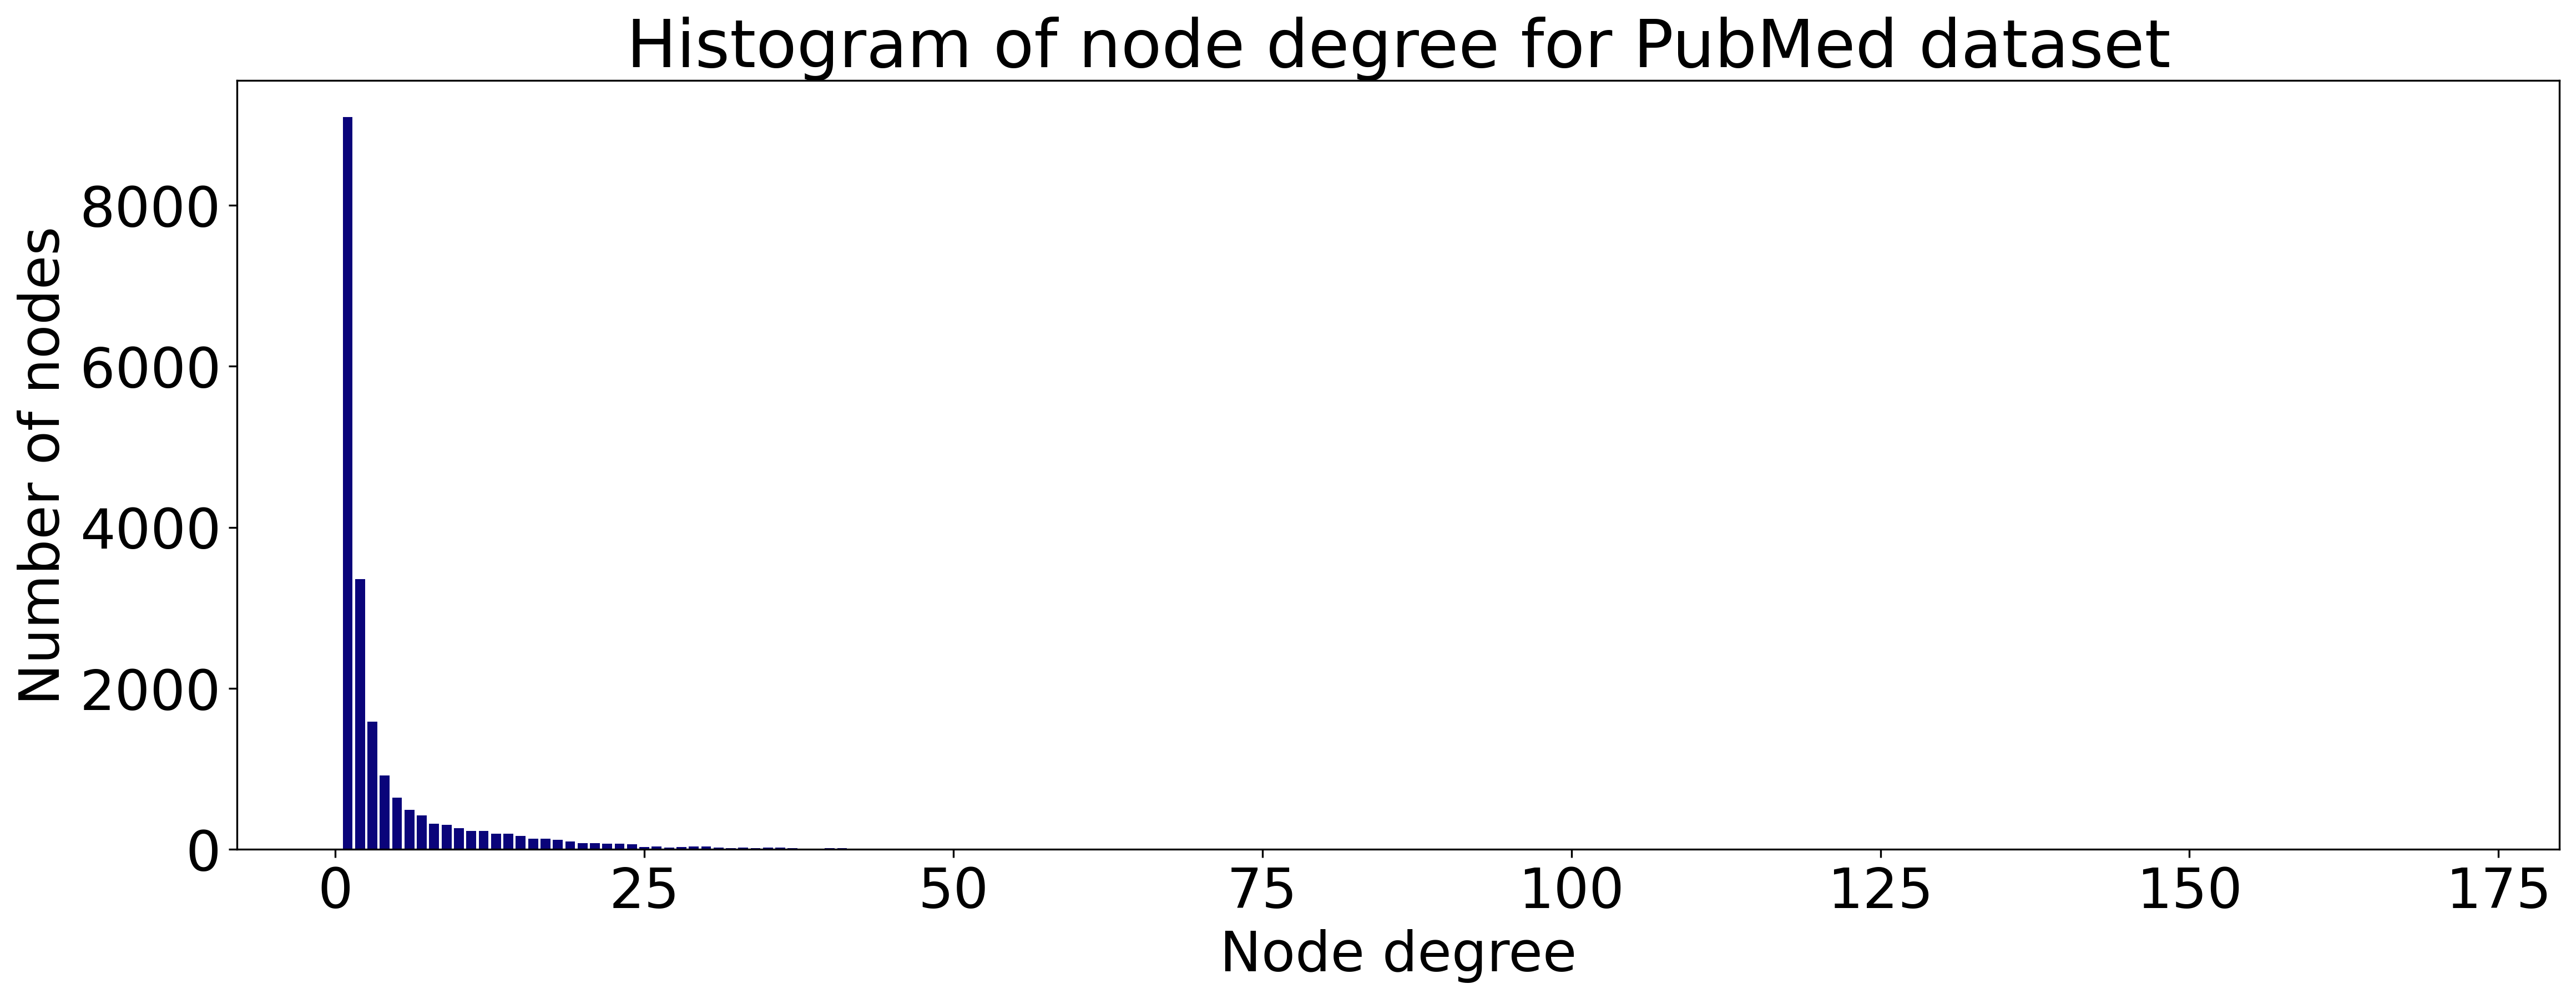

In [ ]:
from torch_geometric.utils import degree
from collections import Counter
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

datasets = ["Cora", "CiteSeer", "PubMed"]

for dataset in datasets:
    datagraph = Planetoid(root = ".", name = dataset)
    data = datagraph[0]

    # print information about the dataset:
    print(f"\n We are using dataset: {datagraph}")

    # Get the list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    ax.set_title(f"Histogram of node degree for {dataset} dataset")
    plt.bar(numbers.keys(),
            numbers.values(),
            color='#0A047A')

## Graph Attention Layer:

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATConv(dim_in, dim_h, heads=heads)
    self.gat2 = GATConv(dim_h*heads, dim_out, heads=1) 
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
# Define a MLP architecture:

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(MLP, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)
        self.dropout = dropout
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    
    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x, edge_index):
        h = F.dropout(x, p=self.dropout, training=self.training)
        h = self.lin1(h)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.lin2(h)
        return x, F.log_softmax(h, dim=1)

### CiteSeer dataset:
#### Experiment on CiteSeer with GCN:

In [ ]:
%%time
citeseer_gcn_test = []

for i in range(10): 
    dataset = Planetoid(root = ".", name = "CiteSeer")
    data = dataset[0]

    # Create GCN
    gcn = GCN(dataset.num_features, 16, dataset.num_classes)
    print(gcn)

    # Train
    train(gcn, data)

    # Test
    acc = test(gcn, data)
    print(f'GCN test accuracy: {acc*100:.2f}%\n')
    citeseer_gcn_test.append(acc)

citeseer_gcn_test = np.array(citeseer_gcn_test)
print(f"Mean test accuracy: {citeseer_gcn_test.mean()}")
print(f"Std test accuracy: {citeseer_gcn_test.std()}")

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.781 | Train Acc:  17.50% | Val Loss: 1.79 | Val Acc: 20.80%
Epoch  10 | Train Loss: 0.504 | Train Acc:  90.00% | Val Loss: 1.36 | Val Acc: 55.60%
Epoch  20 | Train Loss: 0.135 | Train Acc: 100.00% | Val Loss: 1.41 | Val Acc: 57.80%
Epoch  30 | Train Loss: 0.134 | Train Acc:  95.83% | Val Loss: 1.63 | Val Acc: 57.60%
Epoch  40 | Train Loss: 0.049 | Train Acc: 100.00% | Val Loss: 1.55 | Val Acc: 58.20%
Epoch  50 | Train Loss: 0.062 | Train Acc:  99.17% | Val Loss: 1.60 | Val Acc: 53.20%
Epoch  60 | Train Loss: 0.047 | Train Acc:  99.17% | Val Loss: 1.56 | Val Acc: 57.80%
Epoch  70 | Train Loss: 0.050 | Train Acc:  98.33% | Val Loss: 1.52 | Val Acc: 60.20%
Epoch  80 | Train Loss: 0.047 | Train Acc: 100.00% | Val Loss: 1.62 | Val Acc: 59.60%
Epoch  90 | Train Loss: 0.058 | Train Acc:  98.33% | Val Loss: 1.58 | Val Acc: 57.60%
Epoch 100 | Train Loss: 0.045 | Train Acc: 100.00% | Val Loss: 1.58 | Val Acc: 6

#### Experiment on CiteSeer with GAT:

In [ ]:
%%time
citeseer_gat_test = []

for i in range(10):
    # Create GAT
    gat = GAT(dataset.num_features, 16, dataset.num_classes)
    print(gat)

    # Train
    train(gat, data)

    # Test
    acc = test(gat, data)
    print(f'GAT test accuracy: {acc*100:.2f}%\n')
    citeseer_gat_test.append(acc)

citeseer_gat_test = np.array(citeseer_gat_test)
print(f"Mean test accuracy: {citeseer_gat_test.mean()}")
print(f"Std test accuracy: {citeseer_gat_test.std()}")

GAT(
  (gat1): GATConv(3703, 16, heads=8)
  (gat2): GATConv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.806 | Train Acc:  17.50% | Val Loss: 1.80 | Val Acc: 16.40%
Epoch  10 | Train Loss: 0.048 | Train Acc:  98.33% | Val Loss: 1.13 | Val Acc: 63.00%
Epoch  20 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.38 | Val Acc: 63.20%
Epoch  30 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.41 | Val Acc: 63.40%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.36 | Val Acc: 64.80%
Epoch  50 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.27 | Val Acc: 65.80%
Epoch  60 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.17 | Val Acc: 67.00%
Epoch  70 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.13 | Val Acc: 67.20%
Epoch  80 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.08 | Val Acc: 68.40%
Epoch  90 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.08 | Val Acc: 66.40%
Epoch 100 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss

#### Experiment on CiteSeer with MLP:

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
dataset = Planetoid(root = ".", name = "CiteSeer")
data = dataset[0]
citeseer_mlp_test = []

for i in range(10): 
# Create MLP
      mlp = MLP(in_channels = dataset.num_features, hidden_channels = 16, out_channels = dataset.num_classes, dropout = 0.5)
      print(mlp)

      # Train
      train(mlp, data)

      # Test
      acc = test(mlp, data)
      print(f'MLP test accuracy: {acc*100:.2f}%\n')
      citeseer_mlp_test.append(acc) 

citeseer_mlp_test = np.array(citeseer_mlp_test)
print(f"Mean test accuracy: {citeseer_mlp_test.mean()}")
print(f"Std test accuracy: {citeseer_mlp_test.std()}")

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)
Epoch   0 | Train Loss: 1.806 | Train Acc:  14.17% | Val Loss: 1.79 | Val Acc: 22.80%
Epoch  10 | Train Loss: 0.950 | Train Acc:  74.17% | Val Loss: 1.72 | Val Acc: 28.40%
Epoch  20 | Train Loss: 0.389 | Train Acc:  86.67% | Val Loss: 1.90 | Val Acc: 32.60%
Epoch  30 | Train Loss: 0.268 | Train Acc:  88.33% | Val Loss: 2.11 | Val Acc: 34.60%
Epoch  40 | Train Loss: 0.148 | Train Acc:  95.83% | Val Loss: 2.34 | Val Acc: 35.00%
Epoch  50 | Train Loss: 0.214 | Train Acc:  93.33% | Val Loss: 2.46 | Val Acc: 31.80%
Epoch  60 | Train Loss: 0.182 | Train Acc:  92.50% | Val Loss: 2.57 | Val Acc: 29.60%
Epoch  70 | Train Loss: 0.208 | Train Acc:  90.83% | Val Loss: 2.75 | Val Acc: 32.80%
Epoch  80 | Train Loss: 0.157 | Train Acc:  94.17% | Val Loss: 2.53 | Val Acc: 35.40%
Epoch  90 | Train Loss: 0.176 | Train Acc:  94.17% | Val Loss: 2.62 | Val Acc: 33.60%
Epoch 100 

##### Accuracy score on each node degree

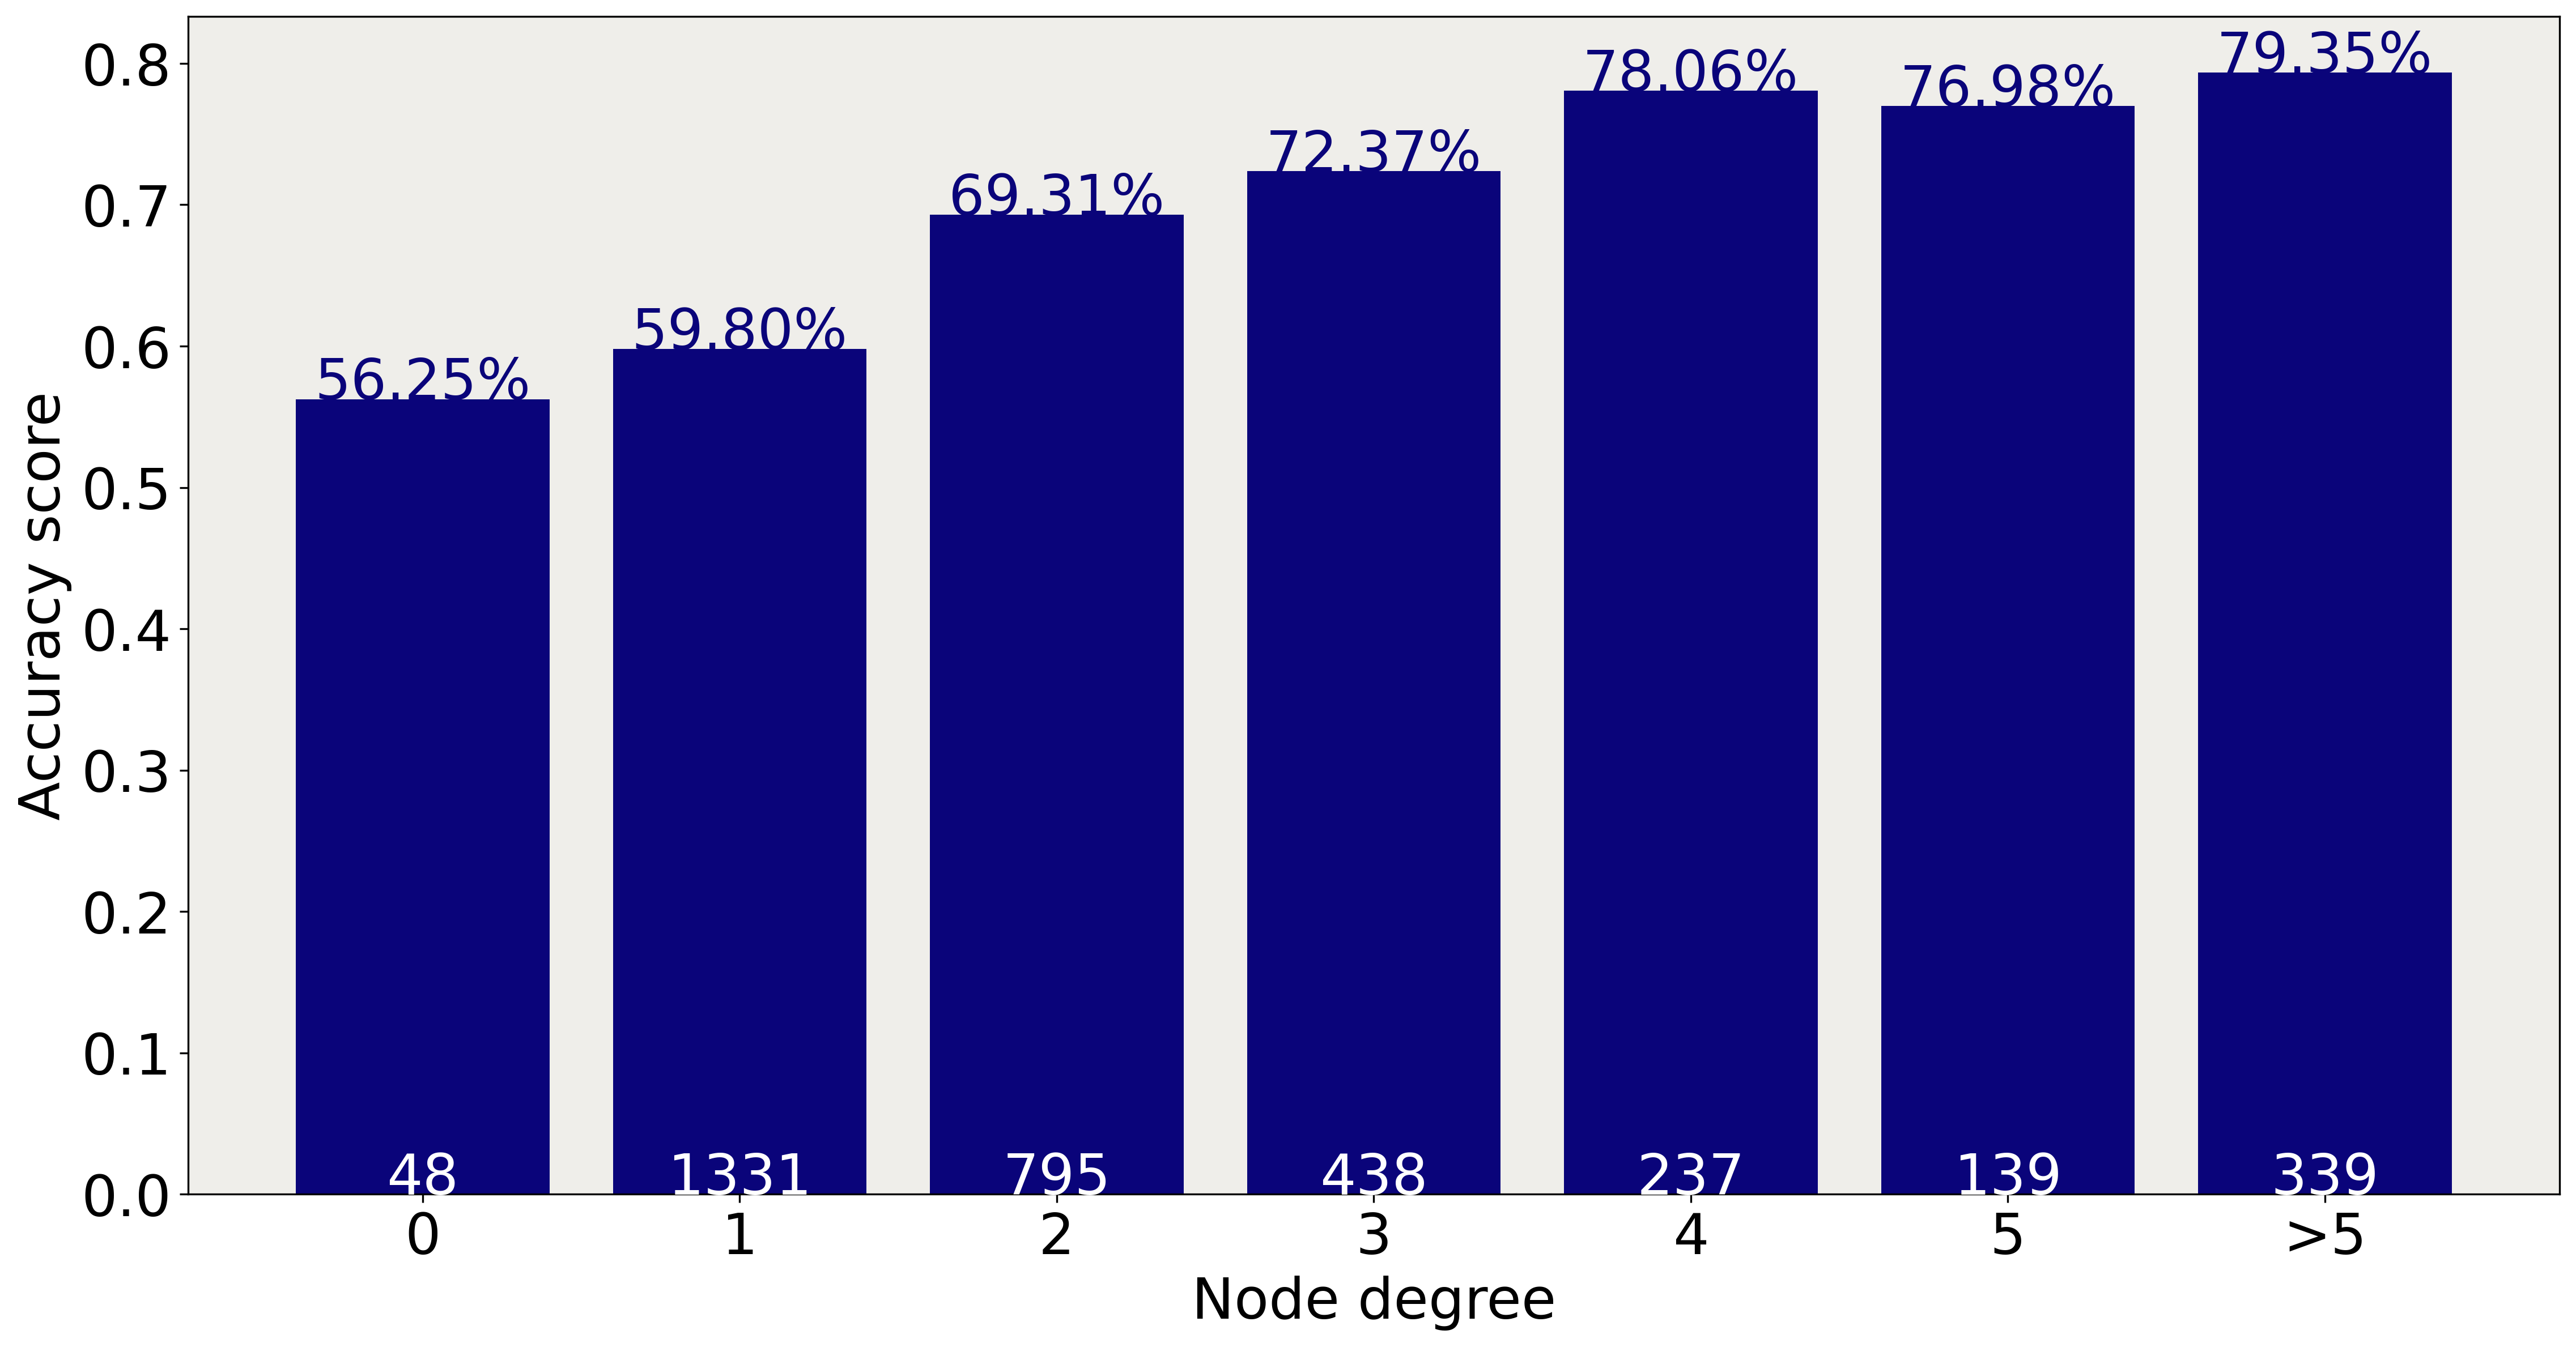

In [ ]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

### Cora dataset:
#### With GCN framework:

In [ ]:
dataset = Planetoid(root = ".", name = "Cora")
data = dataset[0]

cora_gcn_test = []
for i in range(10):
      # Create GCN
      gcn = GCN(dataset.num_features, 16, dataset.num_classes)
      print(gcn)

      # Train
      train(gcn, data)

      # Test
      acc = test(gcn, data)
      print(f'GCN test accuracy: {acc*100:.2f}%\n')
      cora_gcn_test.append(acc)

cora_gcn_test = np.array(cora_gcn_test)
print(f"Mean test accuracy: {cora_gcn_test.mean()}")
print(f"Std test accuracy: {cora_gcn_test.std()}")

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.972 | Train Acc:   8.57% | Val Loss: 1.95 | Val Acc: 16.40%
Epoch  10 | Train Loss: 0.886 | Train Acc:  85.00% | Val Loss: 1.26 | Val Acc: 65.40%
Epoch  20 | Train Loss: 0.290 | Train Acc:  97.14% | Val Loss: 1.01 | Val Acc: 71.00%
Epoch  30 | Train Loss: 0.192 | Train Acc:  95.71% | Val Loss: 0.89 | Val Acc: 72.20%
Epoch  40 | Train Loss: 0.093 | Train Acc:  99.29% | Val Loss: 1.01 | Val Acc: 69.20%
Epoch  50 | Train Loss: 0.060 | Train Acc:  99.29% | Val Loss: 1.00 | Val Acc: 71.60%
Epoch  60 | Train Loss: 0.090 | Train Acc:  97.86% | Val Loss: 1.06 | Val Acc: 70.00%
Epoch  70 | Train Loss: 0.066 | Train Acc:  97.86% | Val Loss: 1.03 | Val Acc: 70.60%
Epoch  80 | Train Loss: 0.054 | Train Acc:  98.57% | Val Loss: 1.05 | Val Acc: 71.60%
Epoch  90 | Train Loss: 0.047 | Train Acc: 100.00% | Val Loss: 1.06 | Val Acc: 70.40%
Epoch 100 | Train Loss: 0.040 | Train Acc: 100.00% | Val Loss: 0.98 | Val Acc: 7

In [ ]:
# Create GAT
cora_gat_test= [] 
for i in range(10):
        gat = GAT(dataset.num_features, 16, dataset.num_classes)
        print(gat)

        # Train
        train(gat, data)

        # Test
        acc = test(gat, data)
        print(f'GAT test accuracy: {acc*100:.2f}%\n')
        cora_gat_test.append(acc)

cora_gat_test = np.array(cora_gat_test)
print(f"Mean test accuracy: {cora_gat_test.mean()}")
print(f"Std test accuracy: {cora_gat_test.std()}")

GAT(
  (gat1): GATConv(1433, 16, heads=8)
  (gat2): GATConv(128, 7, heads=1)
)
Epoch   0 | Train Loss: 1.971 | Train Acc:   8.57% | Val Loss: 1.95 | Val Acc: 15.60%
Epoch  10 | Train Loss: 0.151 | Train Acc:  99.29% | Val Loss: 0.78 | Val Acc: 77.20%
Epoch  20 | Train Loss: 0.024 | Train Acc:  99.29% | Val Loss: 0.81 | Val Acc: 75.40%
Epoch  30 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 0.83 | Val Acc: 75.60%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.90 | Val Acc: 75.00%
Epoch  50 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.94 | Val Acc: 75.40%
Epoch  60 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 0.99 | Val Acc: 74.40%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.99 | Val Acc: 73.40%
Epoch  80 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.01 | Val Acc: 72.60%
Epoch  90 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 0.90 | Val Acc: 73.80%
Epoch 100 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss

In [ ]:
dataset = Planetoid(root = ".", name = "Cora")
data = dataset[0]
cora_mlp_test = []

for i in range(10): 
# Create MLP
      mlp = MLP(in_channels = dataset.num_features, hidden_channels = 16, out_channels = dataset.num_classes, dropout = 0.5)
      print(mlp)

      # Train
      train(mlp, data)

      # Test
      acc = test(mlp, data)
      print(f'MLP test accuracy: {acc*100:.2f}%\n')
      cora_mlp_test.append(acc) 

cora_mlp_test = np.array(cora_mlp_test)
print(f"Mean test accuracy: {cora_mlp_test.mean()}")
print(f"Std test accuracy: {cora_mlp_test.std()}")

Processing...
Done!


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.949 | Train Acc:  14.29% | Val Loss: 1.92 | Val Acc: 26.40%
Epoch  10 | Train Loss: 1.294 | Train Acc:  62.14% | Val Loss: 1.80 | Val Acc: 29.80%
Epoch  20 | Train Loss: 0.779 | Train Acc:  72.14% | Val Loss: 1.82 | Val Acc: 33.00%
Epoch  30 | Train Loss: 0.506 | Train Acc:  85.00% | Val Loss: 1.90 | Val Acc: 36.40%
Epoch  40 | Train Loss: 0.422 | Train Acc:  82.14% | Val Loss: 1.98 | Val Acc: 35.40%
Epoch  50 | Train Loss: 0.328 | Train Acc:  87.14% | Val Loss: 2.28 | Val Acc: 32.20%
Epoch  60 | Train Loss: 0.358 | Train Acc:  84.29% | Val Loss: 2.11 | Val Acc: 37.00%
Epoch  70 | Train Loss: 0.381 | Train Acc:  85.00% | Val Loss: 2.29 | Val Acc: 34.60%
Epoch  80 | Train Loss: 0.315 | Train Acc:  90.71% | Val Loss: 2.41 | Val Acc: 33.60%
Epoch  90 | Train Loss: 0.309 | Train Acc:  84.29% | Val Loss: 2.50 | Val Acc: 35.40%
Epoch 100 

### Pubmed dataset:
#### With GCN framework:

In [ ]:
dataset = Planetoid(root = ".", name = "PubMed")
data = dataset[0]

pubmet_gcn_test = []
for i in range(10):
      # Create GCN
      gcn = GCN(dataset.num_features, 16, dataset.num_classes)
      print(gcn)

      # Train
      train(gcn, data)

      # Test
      acc = test(gcn, data)
      print(f'GCN test accuracy: {acc*100:.2f}%\n')
      pubmet_gcn_test.append(acc)

pubmet_gcn_test = np.array(pubmet_gcn_test)
print(f"Mean test accuracy: {pubmet_gcn_test.mean()}")
print(f"Std test accuracy: {pubmet_gcn_test.std()}")

GCN(
  (gcn1): GCNConv(500, 16)
  (gcn2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.097 | Train Acc:  35.00% | Val Loss: 1.09 | Val Acc: 41.80%
Epoch  10 | Train Loss: 0.910 | Train Acc:  86.67% | Val Loss: 0.98 | Val Acc: 66.60%
Epoch  20 | Train Loss: 0.697 | Train Acc:  88.33% | Val Loss: 0.86 | Val Acc: 67.60%
Epoch  30 | Train Loss: 0.494 | Train Acc:  86.67% | Val Loss: 0.74 | Val Acc: 72.40%
Epoch  40 | Train Loss: 0.354 | Train Acc:  93.33% | Val Loss: 0.69 | Val Acc: 71.40%
Epoch  50 | Train Loss: 0.282 | Train Acc:  96.67% | Val Loss: 0.66 | Val Acc: 74.00%
Epoch  60 | Train Loss: 0.253 | Train Acc:  96.67% | Val Loss: 0.62 | Val Acc: 75.20%
Epoch  70 | Train Loss: 0.233 | Train Acc:  96.67% | Val Loss: 0.64 | Val Acc: 73.60%
Epoch  80 | Train Loss: 0.149 | Train Acc:  98.33% | Val Loss: 0.63 | Val Acc: 73.00%
Epoch  90 | Train Loss: 0.160 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 76.60%
Epoch 100 | Train Loss: 0.115 | Train Acc: 100.00% | Val Loss: 0.68 | Val Acc: 72

In [ ]:
# Create GAT
pubmet_gat_test= [] 
for i in range(10):
        gat = GAT(dataset.num_features, 16, dataset.num_classes)
        print(gat)

        # Train
        train(gat, data)

        # Test
        acc = test(gat, data)
        print(f'GAT test accuracy: {acc*100:.2f}%\n')
        pubmet_gat_test.append(acc)

pubmet_gat_test = np.array(pubmet_gat_test)
print(f"Mean test accuracy: {pubmet_gat_test.mean()}")
print(f"Std test accuracy: {pubmet_gat_test.std()}")

GAT(
  (gat1): GATConv(500, 16, heads=8)
  (gat2): GATConv(128, 3, heads=1)
)
Epoch   0 | Train Loss: 1.090 | Train Acc:  58.33% | Val Loss: 1.10 | Val Acc: 43.00%
Epoch  10 | Train Loss: 0.721 | Train Acc:  91.67% | Val Loss: 0.86 | Val Acc: 74.20%
Epoch  20 | Train Loss: 0.399 | Train Acc:  93.33% | Val Loss: 0.66 | Val Acc: 76.00%
Epoch  30 | Train Loss: 0.198 | Train Acc:  96.67% | Val Loss: 0.57 | Val Acc: 77.20%
Epoch  40 | Train Loss: 0.115 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 79.00%
Epoch  50 | Train Loss: 0.084 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 78.00%
Epoch  60 | Train Loss: 0.067 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 78.00%
Epoch  70 | Train Loss: 0.063 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.058 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 77.40%
Epoch  90 | Train Loss: 0.051 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.049 | Train Acc: 100.00% | Val Loss:

In [ ]:
dataset = Planetoid(root = ".", name = "PubMed")
data = dataset[0]
pubmed_mlp_test = []

for i in range(10): 
# Create MLP
      mlp = MLP(in_channels = dataset.num_features, hidden_channels = 16, out_channels = dataset.num_classes, dropout = 0.5)
      print(mlp)

      # Train
      train(mlp, data)

      # Test
      acc = test(mlp, data)
      print(f'MLP test accuracy: {acc*100:.2f}%\n')
      pubmed_mlp_test.append(acc) 

pubmed_mlp_test = np.array(pubmed_mlp_test)
print(f"Mean test accuracy: {pubmed_mlp_test.mean()}")
print(f"Std test accuracy: {pubmed_mlp_test.std()}")

Processing...
Done!


MLP(
  (lin1): Linear(in_features=500, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)
Epoch   0 | Train Loss: 1.100 | Train Acc:  33.33% | Val Loss: 1.11 | Val Acc: 39.00%
Epoch  10 | Train Loss: 1.005 | Train Acc:  70.00% | Val Loss: 1.06 | Val Acc: 54.60%
Epoch  20 | Train Loss: 0.799 | Train Acc:  90.00% | Val Loss: 1.00 | Val Acc: 53.60%
Epoch  30 | Train Loss: 0.598 | Train Acc:  88.33% | Val Loss: 0.97 | Val Acc: 53.80%
Epoch  40 | Train Loss: 0.399 | Train Acc:  91.67% | Val Loss: 0.94 | Val Acc: 54.60%
Epoch  50 | Train Loss: 0.430 | Train Acc:  86.67% | Val Loss: 0.87 | Val Acc: 58.80%
Epoch  60 | Train Loss: 0.306 | Train Acc:  93.33% | Val Loss: 0.96 | Val Acc: 59.20%
Epoch  70 | Train Loss: 0.271 | Train Acc:  91.67% | Val Loss: 0.96 | Val Acc: 58.00%
Epoch  80 | Train Loss: 0.269 | Train Acc:  90.00% | Val Loss: 1.07 | Val Acc: 56.40%
Epoch  90 | Train Loss: 0.240 | Train Acc:  91.67% | Val Loss: 1.00 | Val Acc: 60.80%
Epoch 100 |